In [13]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
from PIL import Image
from scipy import ndimage
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import pytorch_lightning as pl
import flash 
from flash.image import ImageClassifier
from flash.core.data.data_module import DataModule

%matplotlib inline
np.random.seed(1)

In [15]:
# Loading the data (signs)
def get_imgs_labels(h5_file_path):
    f = h5py.File(h5_file_path, "r")
    ds_keys = [key for key in f.keys()]
    imgs = np.array(f[ds_keys[1]])    
    labels = np.array(f[ds_keys[2]])
    list_classes = np.array(f[ds_keys[0]])
    imgs = np.transpose(imgs, (0, 3, 1, 2))
    return imgs, labels, list_classes

train_x, train_y, train_classes = get_imgs_labels("./datasets/train_signs.h5")
test_x, test_y, test_classes = get_imgs_labels("./datasets/test_signs.h5")
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1080, 3, 64, 64) (1080,)
(120, 3, 64, 64) (120,)


In [16]:
# CONSTANTS

NUM_FOLDS = 5
BATCH_SIZE = 64
NUM_WORKERS = 4

In [20]:
# for a training and label data in form of numpy arrays, return a fold_index array whose elements
# represent the fold index. The length of this fold_index array is same as length of input dataset
# and the items for which fold_index array value == cv iteration count are to be used for validation 
# in the corresponding cross validation iteration with rest of the items ( for which fold_index 
# array value != cv iteration count ) being used for training (typical ration being 80:20)
def get_skf_index(num_folds, X, y):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)
    train_fold_index = np.zeros(len(y))
    for fold, (train_index, val_index) in enumerate(skf.split(X=X, y=y)):
        train_fold_index[val_index] = [fold + 1] * len(val_index)
    return train_fold_index

k_folds = get_skf_index(num_folds=NUM_FOLDS, X=train_x, y=train_y)

In [21]:
def split_data(fold, kfolds, X, y):
    train_X = X[kfolds != fold+1]        
    train_y = y[kfolds != fold+1]    
    val_X = X[kfolds == fold+1]
    val_y = y[kfolds == fold+1]
    return train_X, train_y, val_X, val_y

In [22]:
from flash.image.classification.transforms import default_transforms
from flash.core.data.transforms import ApplyToKeys
from flash.core.data.data_source import DefaultDataKeys, DefaultDataSources
from flash.image import ImageClassificationData

train_X, train_y, val_X, val_y = split_data(0, k_folds, train_x, train_y)

signs_default_transform = {
    "to_tensor_transform": nn.Sequential(
            ApplyToKeys(DefaultDataKeys.INPUT, transforms.ToTensor()),
            ApplyToKeys(DefaultDataKeys.TARGET, torch.as_tensor),
        ),
        "post_tensor_transform": ApplyToKeys(
            DefaultDataKeys.INPUT,
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ),
    "collate": torch.utils.data._utils.collate.default_collate
}

data_module = ImageClassificationData.from_numpy(
    train_data = train_X,
    train_targets= train_y,
    val_data = val_X,
    val_targets = val_y,
    predict_data = test_x,    
    train_transform = signs_default_transform,
    val_transform = signs_default_transform,    
    predict_transform = signs_default_transform,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
)

In [41]:
from flash.image import ImageClassifier
model = ImageClassifier(backbone="resnet18", num_classes=6 )

trainer = flash.Trainer(max_epochs=20, gpus=torch.cuda.device_count())
trainer.finetune(model, datamodule=data_module, strategy="freeze_unfreeze")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params
-------------------------------------------------
0 | train_metrics | ModuleDict     | 0     
1 | val_metrics   | ModuleDict     | 0     
2 | adapter       | DefaultAdapter | 11.2 M
--

Validation sanity check: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/finetuning.py:215: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [74]:
def show_batch(img_np_arr, label_arr, img_index, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(9, 6))
    for index, i in enumerate(img_index):  # list first 9 images
        img_arr, lb = img_np_arr[i], label_arr[i]
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display
        img_arr = img_arr.transpose(1, 2, 0)
        ax.imshow(Image.fromarray(np.uint8(img_arr)).convert('RGB'))
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[i]}"        
        ax.set_title(title)

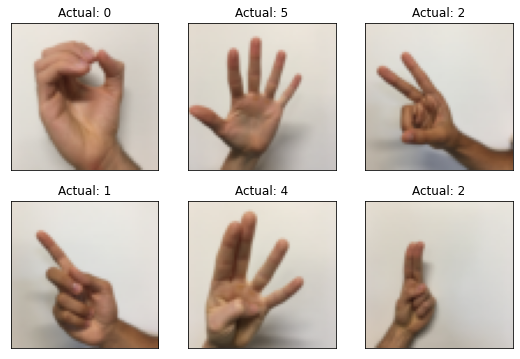

In [70]:
# display image samples from training data
show_batch(train_X, train_y, [0, 1, 2, 3, 4, 5], 2, 3)

In [42]:
predictions = model.predict(test_x, data_source=DefaultDataSources.NUMPY)

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/flash/core/classification.py:217: UserWarning: No LabelsState was found, this serializer will act as a Classes serializer.
  rank_zero_warn("No LabelsState was found, this serializer will act as a Classes serializer.", UserWarning)


Accuracy of Resnet18 on test set is 97.5 %
Incorrect predictions = 3 
Actual label = 2, Predicted label = 1
Actual label = 2, Predicted label = 1
Actual label = 5, Predicted label = 4


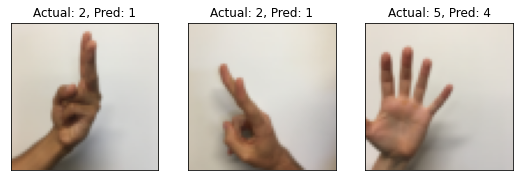

In [75]:
def test_accuracy(test_labels, test_predictions):
    incorrect_preds_index = []
    for index, test_label in enumerate(test_labels):
        if test_label != test_predictions[index] :
            incorrect_preds_index.append(index)

    test_accuracy = (len(test_labels) - len(incorrect_preds_index)) / len(test_labels)
    return round(test_accuracy, 4), incorrect_preds_index

test_acc, test_incorrect_preds = test_accuracy(test_y.tolist(), predictions)
print(f"Accuracy of Resnet18 on test set is {test_acc * 100} %")    
print(f"Incorrect predictions = {len(test_incorrect_preds)} ")
for index in test_incorrect_preds:
    print(f"Actual label = {test_y[index]}, Predicted label = {predictions[index]}")

show_batch(test_x, test_y, img_index=test_incorrect_preds, num_rows=1, num_cols=3, predict_arr=predictions)    

## Incorrect predictions are not that bad. These images are infact confusing.

In [28]:
%tensorboard --logdir lightning_logs/version_6

UsageError: Line magic function `%tensorboard` not found.
